# Lectura y Análisis

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from scipy.spatial.distance import euclidean
from scipy.stats import pearsonr, spearmanr, kendalltau
from sklearn.metrics import mean_squared_error

# Missing values
from scipy.interpolate import PchipInterpolator

from sklearn.neighbors import NearestNeighbors

## Carga de datos

### Lectura de ficheros

Se leen los distintos fichero con la información meteorlógica.

Se establece una cota temporal a los datos de todos los ficheros.

In [24]:
dataframes = {}

def load(file, directory, start_date=None, end_date=None):
    file_path = directory + file + ".csv"
    print(f"Processing {file}...")
    
    try:
        df = pd.read_csv(file_path, parse_dates=['ts'], index_col='ts')
        df = df.sort_index()
        df_hourly = df.resample('h').mean()  # Resample by hour
        
        # Apply date filtering if start_date and end_date are provided
        if start_date and end_date:
            df_hourly = df_hourly.loc[start_date:end_date]
        print(df_hourly.iloc[0])
        print(df_hourly.iloc[-1])
        
        dataframes[file] = df_hourly
    except Exception as e:
        print(f"Error processing {file}: {e}")

In [25]:
# Read the CSV files
directory = "data/"

#########
# Dates #
#########
start_date = "2024-03-01"
end_date = "2025-02-28"

location = "buenavista_norte"

grafcan = "grafcan_buenavista_norte"
openmeteo_arpege = "openmeteo_buenavista_norte_arpege"
openmeteo_icon = "openmeteo_buenavista_norte_icon"

data_files = [grafcan,
              openmeteo_arpege,
              openmeteo_icon]
for file in data_files:
    load(file, directory, start_date, end_date)


Processing grafcan_buenavista_norte...
air_temperature          15.970421
atmospheric_pressure    994.146375
relative_humidity        81.828646
Name: 2024-03-01 00:00:00+00:00, dtype: float64
air_temperature          16.207076
atmospheric_pressure    990.176829
relative_humidity        59.266359
Name: 2025-02-28 23:00:00+00:00, dtype: float64
Processing openmeteo_buenavista_norte_arpege...
air_temperature           18.3
atmospheric_pressure    1013.6
relative_humidity         61.0
Name: 2024-03-01 00:00:00+00:00, dtype: float64
air_temperature           16.5
atmospheric_pressure    1012.1
relative_humidity         70.0
Name: 2025-02-28 23:00:00+00:00, dtype: float64
Processing openmeteo_buenavista_norte_icon...
air_temperature           17.0
atmospheric_pressure    1015.7
relative_humidity         86.0
Name: 2024-03-01 00:00:00+00:00, dtype: float64
air_temperature           15.4
atmospheric_pressure    1013.4
relative_humidity         85.0
Name: 2025-02-28 23:00:00+00:00, dtype: float

## Visualización

In [26]:
def plot_datasets_comparison(dataframes, column):
    """
    Plot a specific column from each dataset (given as a list of filenames)
    for all common years.
    
    Parameters:
        datasets (list): List of dataset filenames (e.g., ['file1.csv', 'file2.csv', ...]).
        column (str): The column name to plot from each dataset.
    """
    print ("Plotting " + column)
    
    df_names = dataframes.keys()
    dfs = dataframes.values()
    # Align all dataframes on their timestamps by concatenating on axis=1 (inner join ensures common timestamps)
    # Using keys creates a hierarchical column index: top level is dataset name, lower level is the original columns.
    combined = pd.concat(dfs, axis=1, join='inner', keys=df_names)
    
    # Ensure the indicated column exists in every dataset
    for name in df_names:
        if column not in combined[name].columns:
            print(f"Column '{column}' not found in dataset '{name}'.")
            return

    # Get all common years from the combined index
    common_years = combined.index.year.unique()
    
    # Plot the indicated column for each dataset by year
    for year in common_years:
        df_year = combined[combined.index.year == year]
        plt.figure(figsize=(10, 6))
        for name in df_names:
            plt.plot(df_year.index, df_year[name][column],
                     label=f"{name}", linestyle='-', alpha=0.7)
        plt.title(f'Comparison Plot - Column "{column}" - Year {year}')
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
        plt.show()

### OpenMeteo

Plotting air_temperature


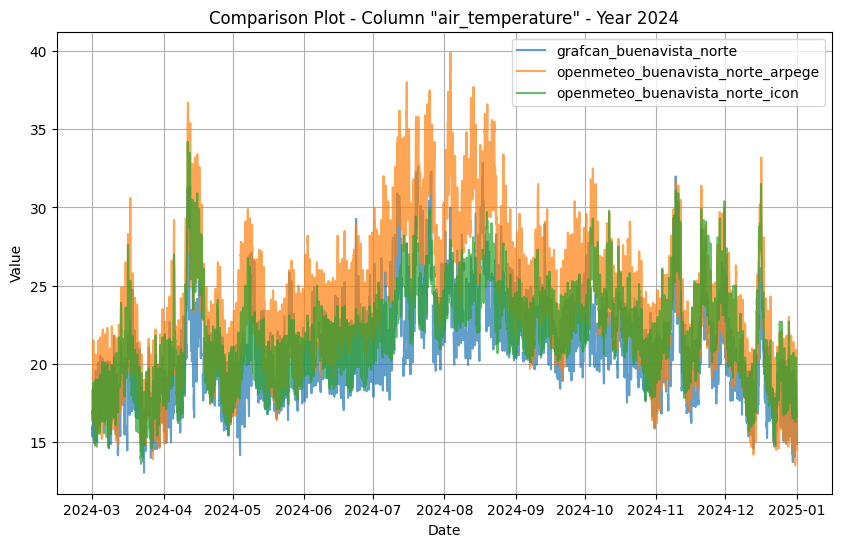

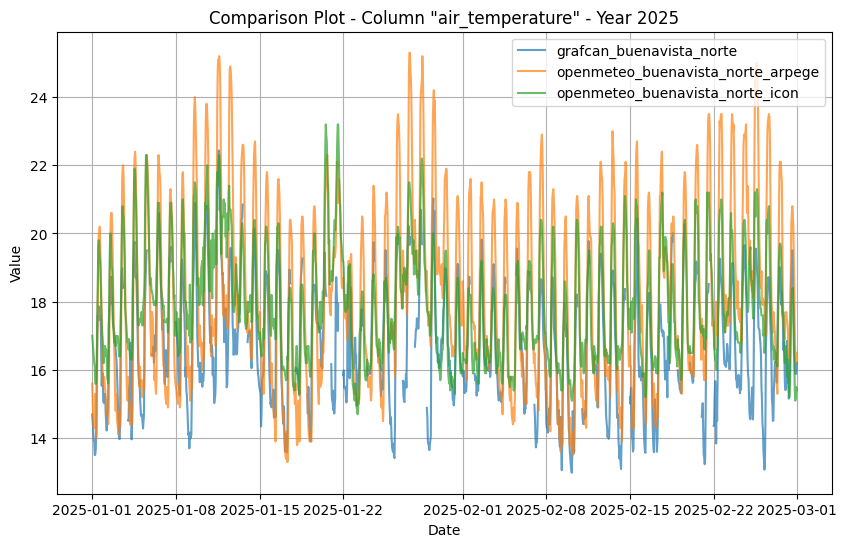

Plotting relative_humidity


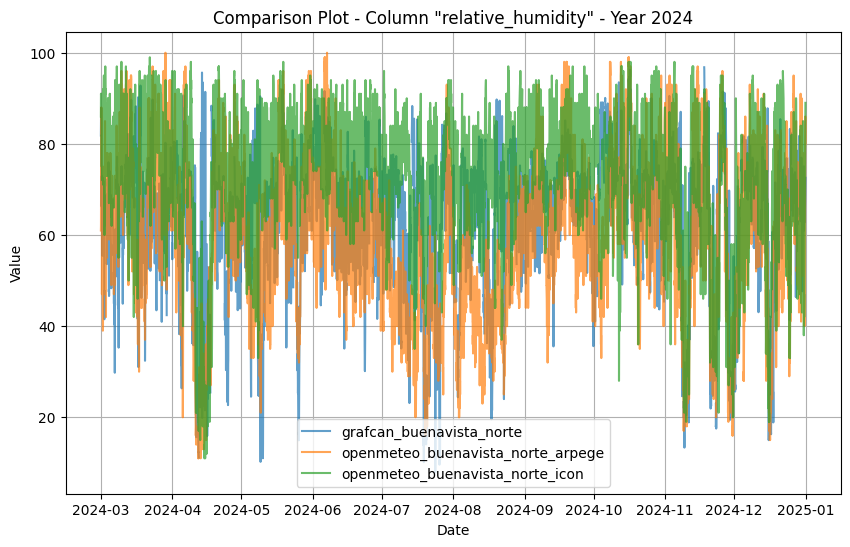

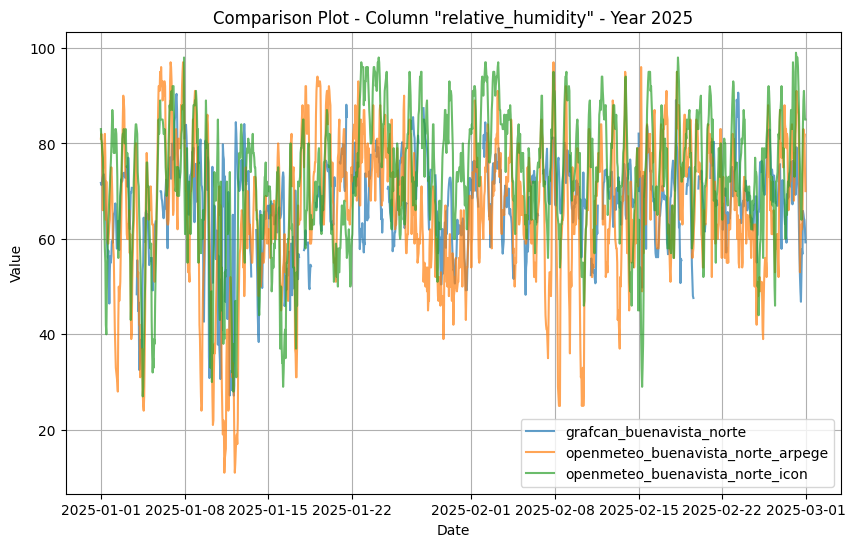

Plotting atmospheric_pressure


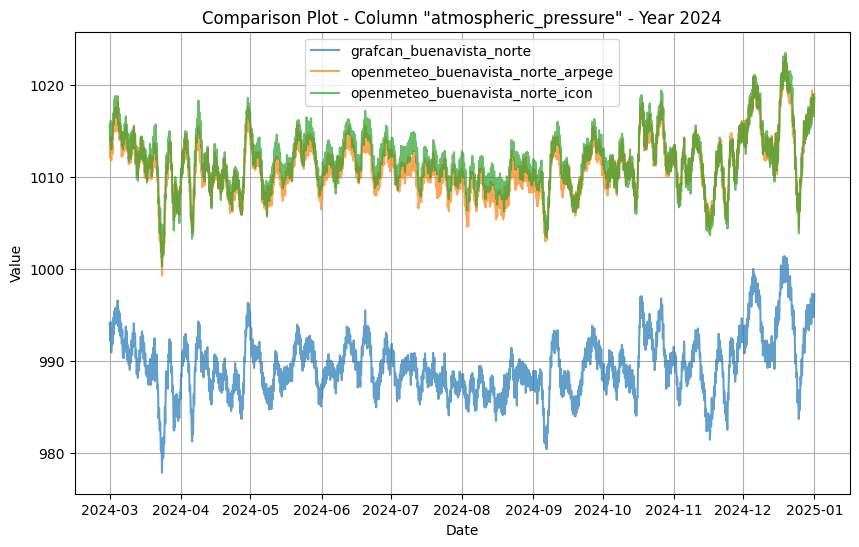

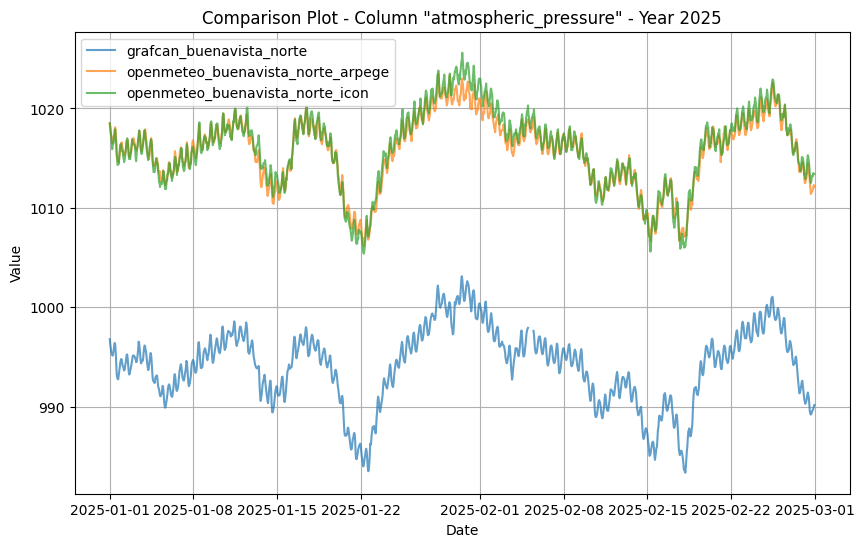

In [27]:
plot_datasets_comparison(dataframes, "air_temperature")
plot_datasets_comparison(dataframes, "relative_humidity")
plot_datasets_comparison(dataframes, "atmospheric_pressure")

## Horas faltantes

In [28]:
for file_key, df_hourly in dataframes.items():
    # Check for missing hours in the time series
    # Detect missing hours after resampling
    missing_hours = df_hourly[df_hourly.isna().any(axis=1)].index

    # Print missing hours if any
    if len(missing_hours) > 0:
        print(f"Missing hours in {file_key} after resampling:")
        print(missing_hours.tolist())
        print(len(missing_hours))
    else:
        print(f"No missing hours in {file_key} after resampling.")

Missing hours in grafcan_buenavista_norte after resampling:
[Timestamp('2024-03-02 15:00:00+0000', tz='UTC'), Timestamp('2024-03-02 16:00:00+0000', tz='UTC'), Timestamp('2024-03-02 17:00:00+0000', tz='UTC'), Timestamp('2024-03-02 18:00:00+0000', tz='UTC'), Timestamp('2024-03-02 19:00:00+0000', tz='UTC'), Timestamp('2024-03-02 20:00:00+0000', tz='UTC'), Timestamp('2024-03-02 21:00:00+0000', tz='UTC'), Timestamp('2024-03-02 22:00:00+0000', tz='UTC'), Timestamp('2024-03-02 23:00:00+0000', tz='UTC'), Timestamp('2024-03-05 15:00:00+0000', tz='UTC'), Timestamp('2024-03-05 16:00:00+0000', tz='UTC'), Timestamp('2024-03-05 17:00:00+0000', tz='UTC'), Timestamp('2024-03-05 18:00:00+0000', tz='UTC'), Timestamp('2024-03-05 19:00:00+0000', tz='UTC'), Timestamp('2024-03-05 20:00:00+0000', tz='UTC'), Timestamp('2024-03-05 21:00:00+0000', tz='UTC'), Timestamp('2024-03-05 22:00:00+0000', tz='UTC'), Timestamp('2024-03-05 23:00:00+0000', tz='UTC'), Timestamp('2024-03-15 15:00:00+0000', tz='UTC'), Timestam

### Manejo Horas faltantes

In [29]:
# Pchip Interpolation Algorithm
def pchip_interpolation(df):
    # Ensure index is datetime and convert to numeric (Unix timestamp in seconds)
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("Index must be a DatetimeIndex.")

    numeric_index = df.index.astype('int64') // 10**9

    # Initialize artificial_value column with zeros if not present
    if "artificial_value" not in df.columns:
        df["artificial_value_flag"] = 0

    for col in df.columns:
        if col == "artificial_value":
            continue  # Skip flag column

        valid_mask = ~df[col].isna()

        if valid_mask.sum() >= 2:
            pchip = PchipInterpolator(numeric_index[valid_mask], df.loc[valid_mask, col])
            interpolated_values = pchip(numeric_index)

            # Mark artificially generated values before filling
            nan_mask = df[col].isna()
            df.loc[nan_mask, col] = interpolated_values[nan_mask]
            df.loc[nan_mask, "artificial_value_flag"] = 1
        else:
            print(f"Not enough data points to interpolate column '{col}'.")

    return df

#cs = CubicSpline(numeric_index[valid_mask], df.loc[valid_mask, col], bc_type='natural')

In [30]:
for file_key, df_hourly in dataframes.items():
    # Perform cubic spline interpolation on the dataframe
    pchip_interpolation(df_hourly)

## Comparativa datasets openmeteo

In [31]:
def datasets_similarity(file1, file2):
    # Remove .csv extension if present
    file1 = file1.replace(".csv", "")
    file2 = file2.replace(".csv", "")
    
    # Ensure datasets are loaded
    if file1 not in dataframes or file2 not in dataframes:
        print("One or both datasets are not loaded.")
        return
    
    # Retrieve dataframes and align by timestamp
    df1 = dataframes[file1].drop(columns=["artificial_value_flag"])
    df2 = dataframes[file2].drop(columns=["artificial_value_flag"])
    df1, df2 = df1.align(df2, join='inner')
    
    similarity_results = {}
    for column in df1.columns:
        if column in df2.columns:
            try:
                pearson_corr, _ = pearsonr(df1[column], df2[column])
                spearman_corr, _ = spearmanr(df1[column], df2[column])
                kendall_corr, _ = kendalltau(df1[column], df2[column])
                mse = mean_squared_error(df1[column], df2[column])
                euclid_dist = euclidean(df1[column], df2[column])
                
                similarity_results[column] = {
                    "Pearson": pearson_corr,
                    "Spearman": spearman_corr,
                    "Kendall": kendall_corr,
                    "MSE": mse,
                    "Euclidean Distance": euclid_dist
                }
            except Exception as e:
                print(f"Error calculating similarity for {column}: {e}")
    
    print(f"Similarity Metrics for {file1} vs {file2}")
    for col, metrics in similarity_results.items():
        print(f"  {col}:")
        for metric, value in metrics.items():
            print(f"    {metric}: {value:.4f}")


In [32]:
datasets_similarity(openmeteo_icon, grafcan)

Similarity Metrics for openmeteo_buenavista_norte_icon vs grafcan_buenavista_norte
  air_temperature:
    Pearson: 0.8404
    Spearman: 0.8797
    Kendall: 0.6948
    MSE: 4.1431
    Euclidean Distance: 190.5085
  atmospheric_pressure:
    Pearson: 0.9667
    Spearman: 0.9554
    Kendall: 0.8285
    MSE: 498.3201
    Euclidean Distance: 2089.3263
  relative_humidity:
    Pearson: 0.3964
    Spearman: 0.2826
    Kendall: 0.2014
    MSE: 339.8881
    Euclidean Distance: 1725.5201


In [33]:
datasets_similarity(openmeteo_arpege, grafcan)

Similarity Metrics for openmeteo_buenavista_norte_arpege vs grafcan_buenavista_norte
  air_temperature:
    Pearson: 0.8812
    Spearman: 0.9037
    Kendall: 0.7280
    MSE: 12.3505
    Euclidean Distance: 328.9233
  atmospheric_pressure:
    Pearson: 0.9820
    Spearman: 0.9772
    Kendall: 0.8794
    MSE: 468.7170
    Euclidean Distance: 2026.3171
  relative_humidity:
    Pearson: 0.4906
    Spearman: 0.4087
    Kendall: 0.2898
    MSE: 270.6194
    Euclidean Distance: 1539.6838


### Selección de datasets

In [34]:
ned_df_openmeteo = "openmeteo_" + location
dataframes[ned_df_openmeteo] = dataframes[openmeteo_icon].copy()
dataframes[ned_df_openmeteo]["atmospheric_pressure"] = dataframes[openmeteo_arpege]["atmospheric_pressure"].copy()
dataframes[ned_df_openmeteo]["artificial_value_flag"] += dataframes[openmeteo_arpege]["artificial_value_flag"]

# Erase individual dataframes
del dataframes[openmeteo_icon]
del dataframes[openmeteo_arpege]

## Detección de outliers



### Análisis IQR

In [35]:
def detect_outliers_iqr(df, columns, threshold=1.5, return_indices=False):
    """
    Detects and plots outliers in each numerical column of a Pandas DataFrame using the Interquartile Range (IQR) method.
    Optionally returns indices of the detected outliers.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame.
        threshold (float): The multiplier for the IQR to determine outlier boundaries.
        return_indices (bool): If True, also return a dictionary of outlier indices for each column.
        
    Returns:
        outliers_dict (dict): A dictionary containing outlier values for each numerical column.
        outlier_indices_dict (dict, optional): A dictionary containing outlier row indices for each numerical column.
    """
    outliers_dict = {}
    outlier_indices_dict = {}
    
    for column in df[columns].columns:
        # Calculate IQR-based bounds
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        
        # Identify outliers
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
        outliers_dict[column] = outliers.tolist()
        outlier_indices_dict[column] = outliers.index.tolist()
        
        # Create subplots for boxplot and histogram
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
        
        # Boxplot on the left with outliers highlighted
        ax1.boxplot(df[column], vert=False)
        ax1.scatter(outliers, [1] * len(outliers), color='red', label='Outliers')
        ax1.set_title(f'Boxplot of {column}')  # Fixed typo here
        ax1.set_xlabel(column)
        ax1.legend()
        
        # Histogram on the right with bounds indicated
        ax2.hist(df[column], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
        ax2.axvline(lower_bound, color='red', linestyle='dashed', linewidth=1, label='Lower bound')
        ax2.axvline(upper_bound, color='red', linestyle='dashed', linewidth=1, label='Upper bound')
        ax2.set_title(f'Histogram of {column}')
        ax2.set_xlabel(column)
        ax2.set_ylabel('Frequency')
        ax2.legend()
        
        plt.tight_layout()
        plt.show()
    
    if return_indices:
        return outliers_dict, outlier_indices_dict
    return outliers_dict


Processing grafcan_buenavista_norte:


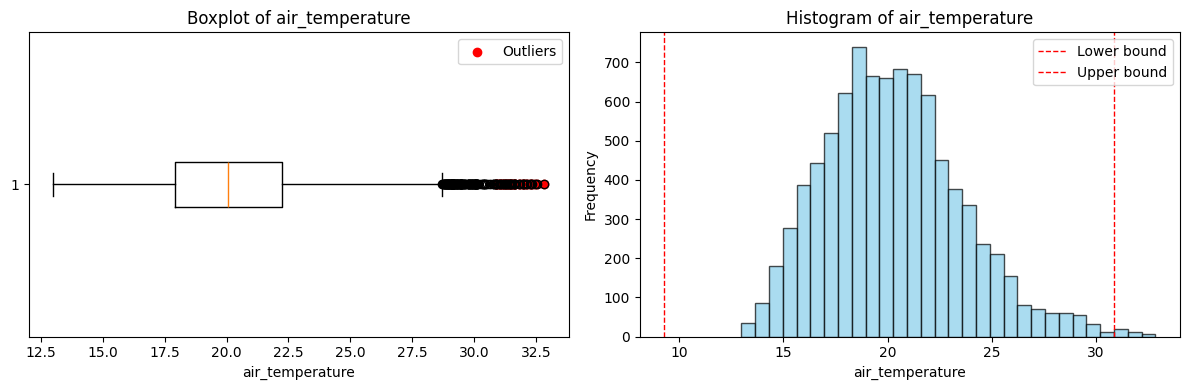

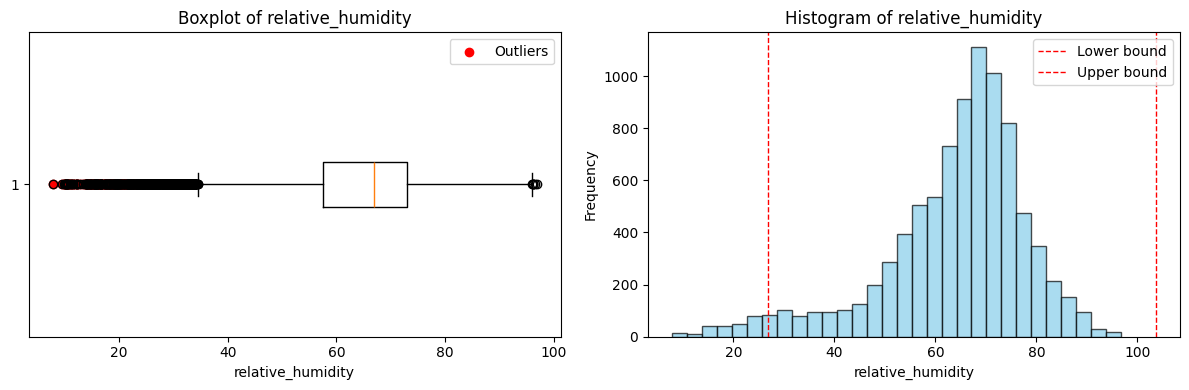

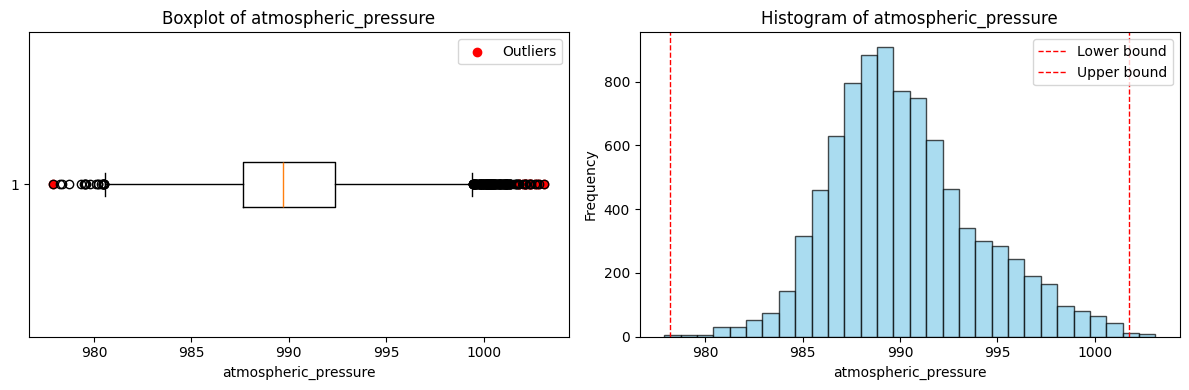

  air_temperature outlier row indices: [Timestamp('2024-04-11 11:00:00+0000', tz='UTC'), Timestamp('2024-04-11 12:00:00+0000', tz='UTC'), Timestamp('2024-04-12 12:00:00+0000', tz='UTC'), Timestamp('2024-04-12 13:00:00+0000', tz='UTC'), Timestamp('2024-04-12 14:00:00+0000', tz='UTC'), Timestamp('2024-07-11 13:00:00+0000', tz='UTC'), Timestamp('2024-07-19 13:00:00+0000', tz='UTC'), Timestamp('2024-07-19 14:00:00+0000', tz='UTC'), Timestamp('2024-07-19 15:00:00+0000', tz='UTC'), Timestamp('2024-07-20 07:00:00+0000', tz='UTC'), Timestamp('2024-07-20 08:00:00+0000', tz='UTC'), Timestamp('2024-07-20 09:00:00+0000', tz='UTC'), Timestamp('2024-07-20 10:00:00+0000', tz='UTC'), Timestamp('2024-07-20 12:00:00+0000', tz='UTC'), Timestamp('2024-07-20 13:00:00+0000', tz='UTC'), Timestamp('2024-07-20 14:00:00+0000', tz='UTC'), Timestamp('2024-07-20 15:00:00+0000', tz='UTC'), Timestamp('2024-07-20 16:00:00+0000', tz='UTC'), Timestamp('2024-07-25 23:00:00+0000', tz='UTC'), Timestamp('2024-07-26 00:00:0

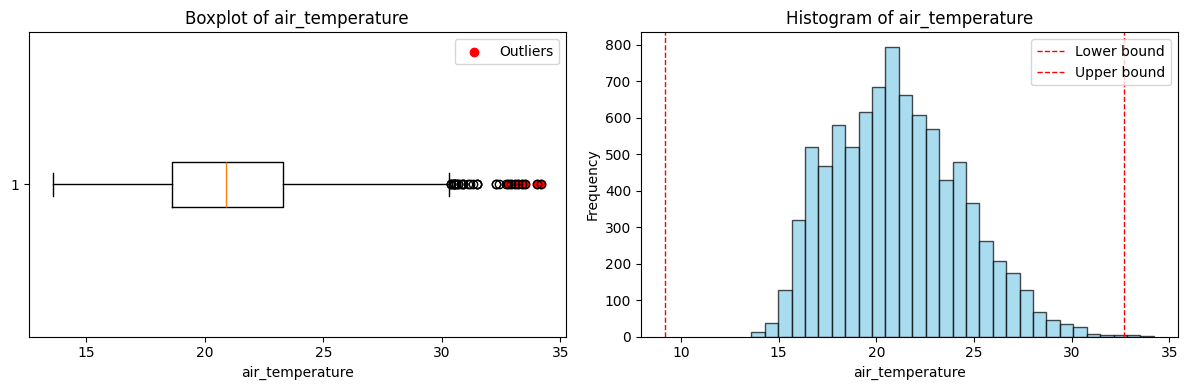

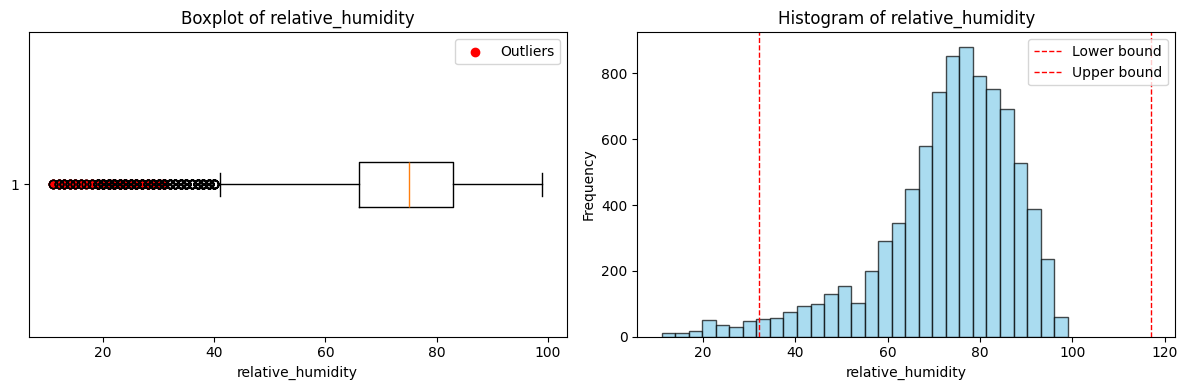

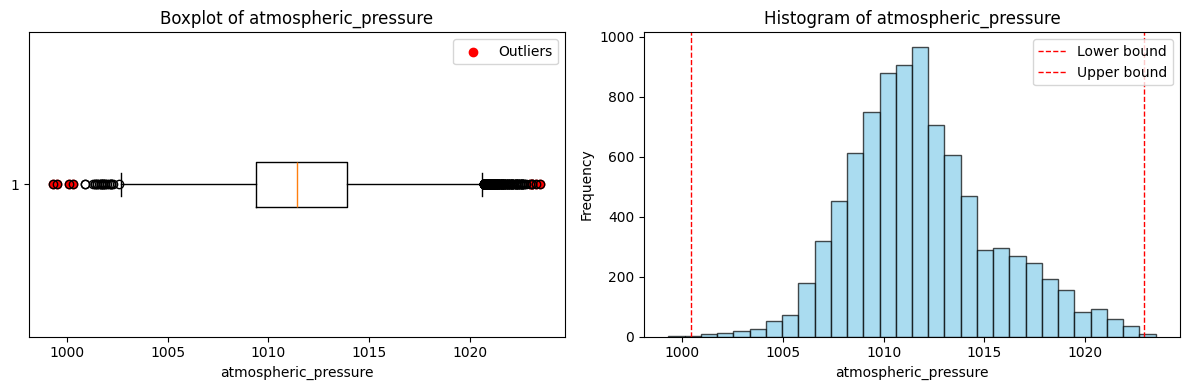

  air_temperature outlier row indices: [Timestamp('2024-04-11 11:00:00+0000', tz='UTC'), Timestamp('2024-04-11 12:00:00+0000', tz='UTC'), Timestamp('2024-04-11 13:00:00+0000', tz='UTC'), Timestamp('2024-04-11 14:00:00+0000', tz='UTC'), Timestamp('2024-04-12 10:00:00+0000', tz='UTC'), Timestamp('2024-04-12 11:00:00+0000', tz='UTC'), Timestamp('2024-04-12 12:00:00+0000', tz='UTC'), Timestamp('2024-04-12 13:00:00+0000', tz='UTC')]
  relative_humidity outlier row indices: [Timestamp('2024-04-11 03:00:00+0000', tz='UTC'), Timestamp('2024-04-11 04:00:00+0000', tz='UTC'), Timestamp('2024-04-11 05:00:00+0000', tz='UTC'), Timestamp('2024-04-11 06:00:00+0000', tz='UTC'), Timestamp('2024-04-11 07:00:00+0000', tz='UTC'), Timestamp('2024-04-11 08:00:00+0000', tz='UTC'), Timestamp('2024-04-11 09:00:00+0000', tz='UTC'), Timestamp('2024-04-11 10:00:00+0000', tz='UTC'), Timestamp('2024-04-11 11:00:00+0000', tz='UTC'), Timestamp('2024-04-11 12:00:00+0000', tz='UTC'), Timestamp('2024-04-11 13:00:00+0000'

In [36]:
threshold = 2
columns = ["air_temperature", "relative_humidity", "atmospheric_pressure"]

for file_key, df_hourly in dataframes.items():
    print(f"Processing {file_key}:")
    
    # Use the modified function to get both outlier values and their indices
    outliers, outlier_indices = detect_outliers_iqr(df_hourly, columns, threshold, return_indices=True)
    
    # Print outliers for each column
    for column, indices in outlier_indices.items():
        print(f"  {column} outlier row indices: {indices}")
    
    # Combine all outlier indices from every column
    all_outlier_indices = set()
    for indices in outlier_indices.values():
        all_outlier_indices.update(indices)
    
    # Remove rows with any detected outlier
    # df_clean = df_hourly.drop(list(all_outlier_indices))
    # dataframes[file_key] = df_clean
    
    print(f"Detected {len(all_outlier_indices)} rows with outliers from {file_key}.\n")

### KNN

Processing grafcan_buenavista_norte for KNN outlier detection...
air_temperature


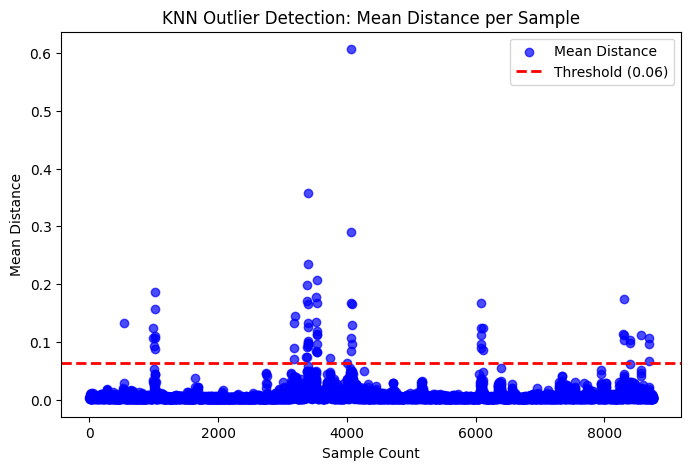

Detected 66 outliers at indices: [ 541  994  995  996 1019 1020 1021 1022 1023 3181 3182 3183 3201 3372
 3373 3374 3375 3387 3391 3392 3393 3394 3395 3396 3397 3398 3399 3400
 3514 3527 3528 3529 3530 3531 3532 3533 3534 3535 3536 3731 3997 4065
 4066 4070 4071 4072 4073 4074 4078 6081 6082 6083 6084 6085 6109 6111
 8287 8305 8306 8307 8405 8406 8574 8693 8694 8695]
atmospheric_pressure


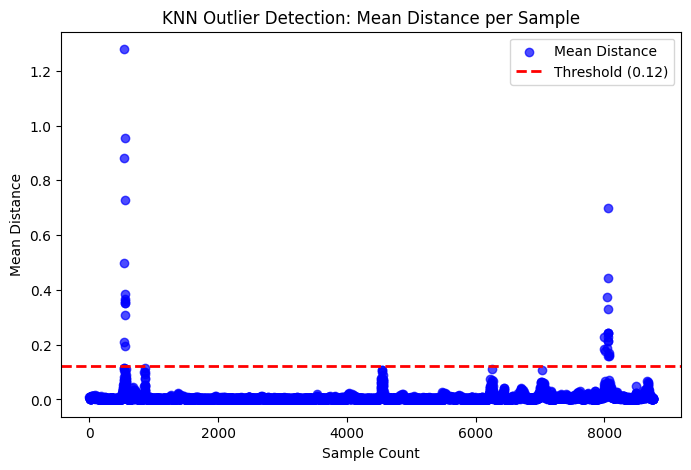

Detected 31 outliers at indices: [ 535  542  543  544  545  546  547  548  555  556  557  558  559 8002
 8003 8004 8049 8050 8051 8052 8053 8059 8060 8061 8062 8063 8064 8065
 8066 8074 8075]
relative_humidity


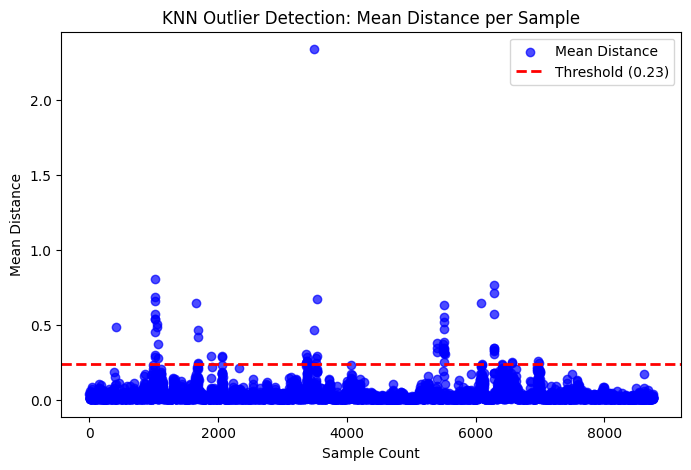

Detected 71 outliers at indices: [ 413 1016 1017 1018 1019 1020 1021 1022 1023 1025 1053 1054 1059 1060
 1663 1680 1687 1688 1689 1893 2058 2059 3364 3366 3367 3374 3383 3387
 3388 3397 3399 3485 3486 3527 3528 3529 3535 5398 5399 5400 5498 5499
 5500 5501 5502 5504 5505 5506 5511 5512 5513 5514 5515 5516 5517 5519
 6082 6100 6283 6284 6285 6286 6287 6288 6289 6290 6416 6559 6560 6969
 6985]
Processing openmeteo_buenavista_norte for KNN outlier detection...
air_temperature


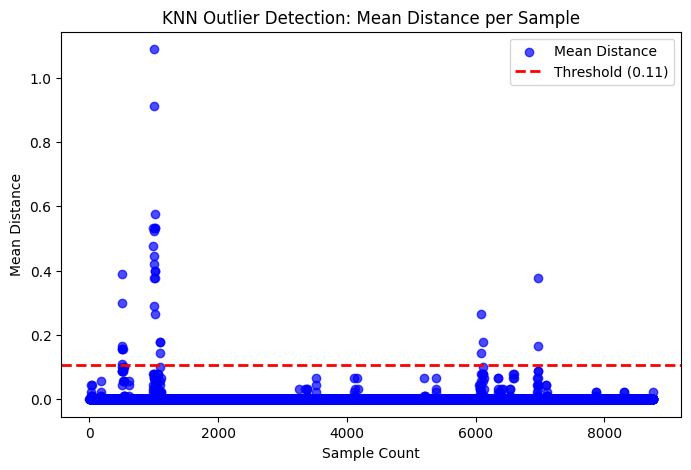

Detected 31 outliers at indices: [ 504  505  508  510  511  512  525  994  995  996  997  998  999 1000
 1001 1002 1017 1018 1019 1020 1021 1022 1023 1094 1095 1096 6083 6085
 6108 6971 6972]
atmospheric_pressure


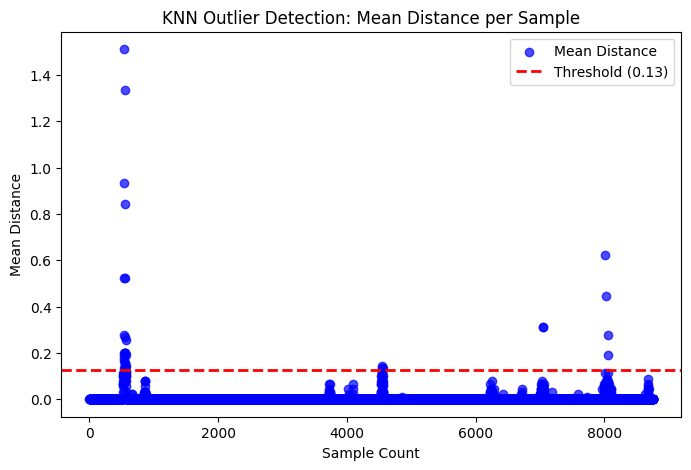

Detected 34 outliers at indices: [ 531  532  534  536  537  540  542  543  544  545  546  547  548  549
  550  553  554  555  556  557  558  559  561  562  568 4545 4553 4556
 7043 7044 8004 8027 8051 8052]
relative_humidity


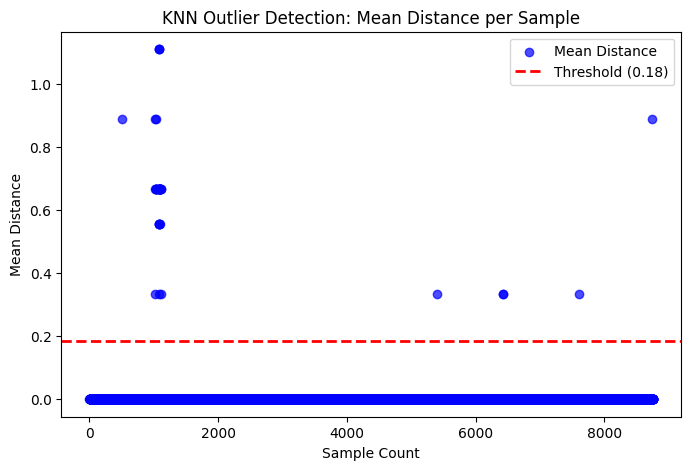

Detected 39 outliers at indices: [ 510 1018 1019 1021 1032 1033 1034 1035 1036 1037 1062 1076 1077 1078
 1079 1080 1081 1082 1083 1084 1085 1086 1087 1088 1089 1090 1096 1097
 1101 1102 1103 1105 1113 1115 5400 6432 6433 7610 8740]


In [37]:
def knn_outlier_detection(data, k=10, threshold=4):
    """
    Detect outliers using K-Nearest Neighbors.
    
    Parameters:
    - data: 1D numpy array of values.
    - k: Number of neighbors to consider.
    - threshold: Multiplier for the mean distance to determine outliers.
    
    Returns:
    - outliers: Indices of detected outliers.
    """
    data = data.reshape(-1, 1)  # Reshape for sklearn compatibility
    
    nbrs = NearestNeighbors(n_neighbors=k)
    nbrs.fit(data)
    distances, _ = nbrs.kneighbors(data)
    
    mean_distances = distances[:, 1:].mean(axis=1)  # Ignore self-distance (0)
    
    threshold_value = mean_distances.mean() + threshold * mean_distances.std()
    outliers = np.where(mean_distances > threshold_value)[0]
    
    # Plot distance distribution with better bin scaling
    plt.figure(figsize=(8, 5))
    plt.scatter(np.arange(len(mean_distances)), mean_distances, color='b', alpha=0.7, label='Mean Distance')
    plt.axhline(threshold_value, color='r', linestyle='dashed', linewidth=2,
                label=f'Threshold ({threshold_value:.2f})')
    #plt.yscale('log')  # Log scale for y-axis
    plt.xlabel('Sample Count')
    plt.ylabel('Mean Distance')
    plt.title('KNN Outlier Detection: Mean Distance per Sample')
    plt.legend()
    plt.show()
    
    print(f"Detected {len(outliers)} outliers at indices: {outliers}")
    
    return outliers

for name, df in dataframes.items(): 
    print(f"Processing {name} for KNN outlier detection...")
    
    # Flag outliers initialized at 0
    flag = np.zeros(len(df), dtype=int)

    print("air_temperature")
    data = df["air_temperature"].values
    outliers = knn_outlier_detection(data)
    flag[outliers] = 1

    print("atmospheric_pressure")
    data = df["atmospheric_pressure"].values
    outliers = knn_outlier_detection(data)
    flag[outliers] = 1
    
    print("relative_humidity")
    data = df["relative_humidity"].values
    outliers = knn_outlier_detection(data)
    flag[outliers] = 1

    # Assign this flag array as a new column
    df["outlier_flag"] = flag

Plotting histogram for grafcan_buenavista_norte...


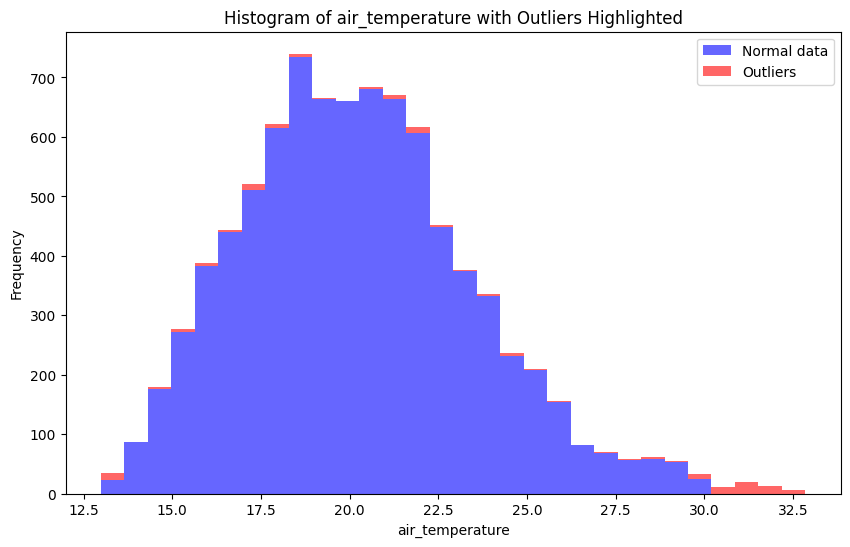

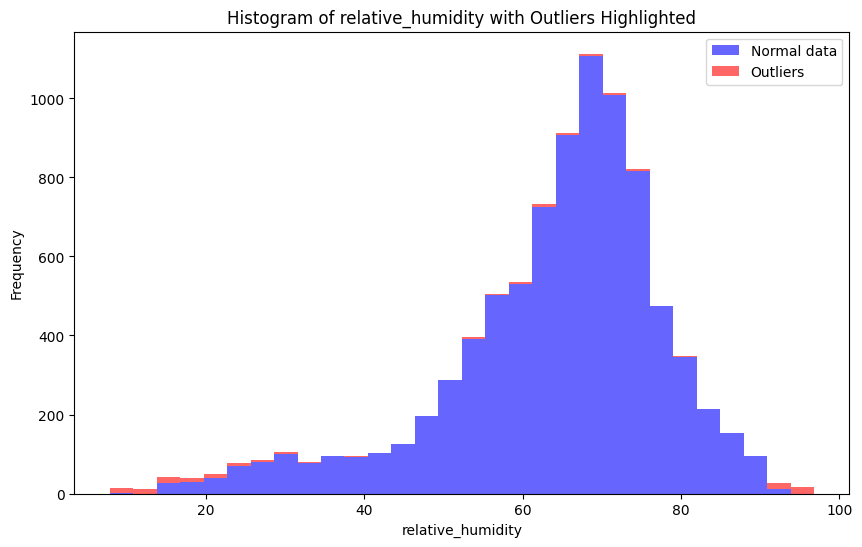

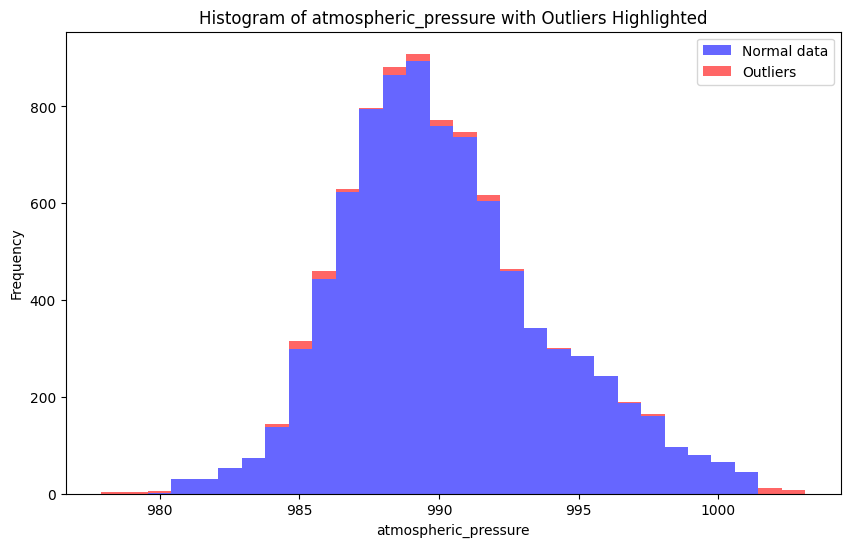

Plotting histogram for openmeteo_buenavista_norte...


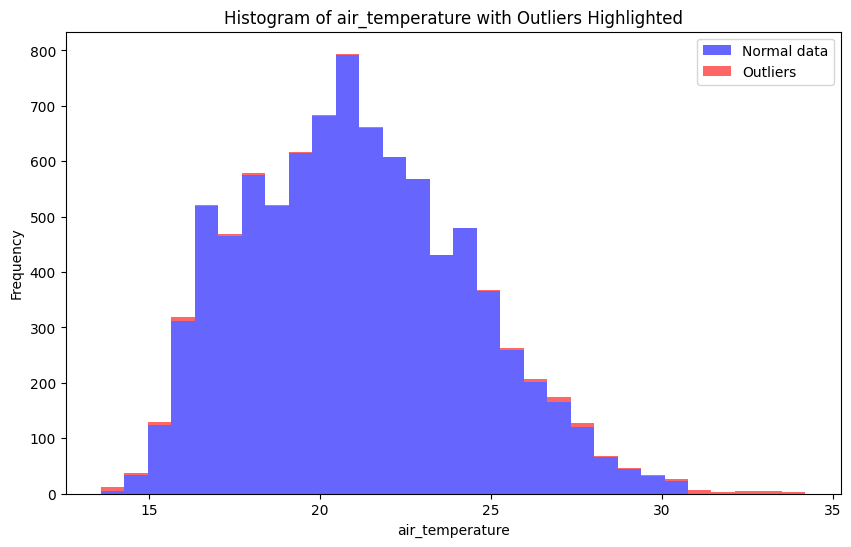

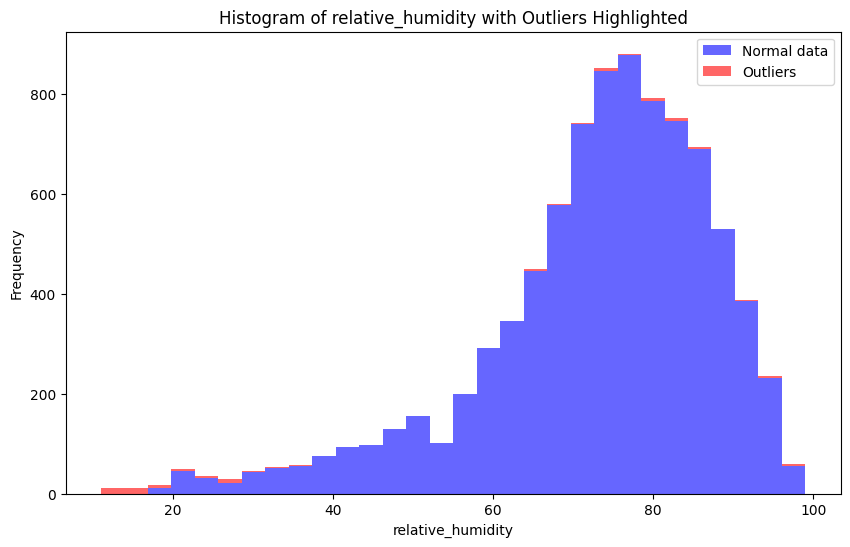

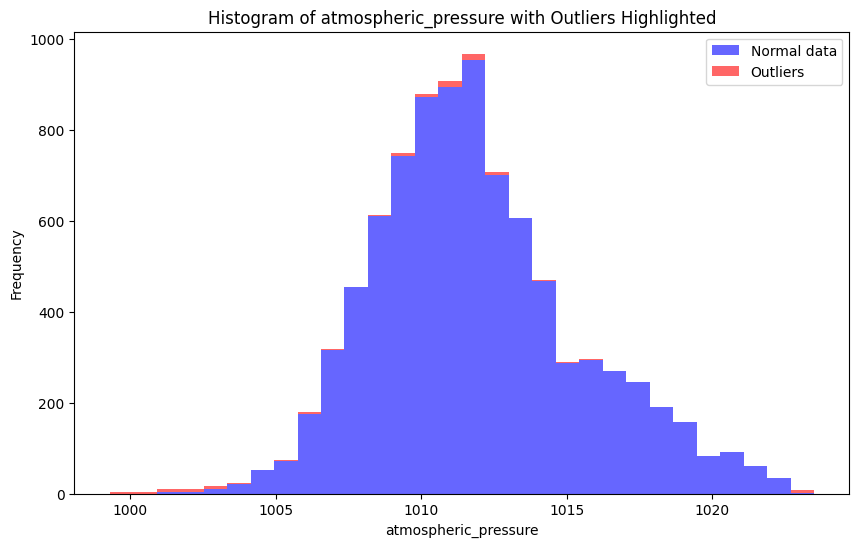

In [38]:
def plot_histogram_with_outliers(df, column, outlier_flag_column='outlier_flag', bins=30):
    """
    Plots a histogram for a specified column in the DataFrame, highlighting outliers.
    
    Parameters:
    - df: DataFrame containing the data.
    - column: Column name (string) for which to plot the histogram.
    - outlier_flag_column: Column name (string) containing the outlier flags (default 'outlier_flag').
    - bins: Number of bins for the histogram (default 30).
    """
    plt.figure(figsize=(10, 6))
    

    # Define bin edges based on the full dataset
    bin_edges = np.histogram_bin_edges(df[column], bins=bins)
    
    # Plot normal data histogram
    plt.hist([df.loc[df[outlier_flag_column] == 0, column], df.loc[df[outlier_flag_column] == 1, column]], stacked=True, bins=bin_edges, 
             color=['blue', 'red'], alpha=0.6, label=['Normal data', 'Outliers'])
    
    plt.xlabel(column)
    plt.ylabel("Frequency")
    #plt.yscale('log')  # Log scale for y-axis
    plt.title(f"Histogram of {column} with Outliers Highlighted")
    plt.legend()
    plt.show()

# Example usage:
for df_key in dataframes.keys():
    print(f"Plotting histogram for {df_key}...")
    plot_histogram_with_outliers(dataframes[df_key], "air_temperature")
    plot_histogram_with_outliers(dataframes[df_key], "relative_humidity")
    plot_histogram_with_outliers(dataframes[df_key], "atmospheric_pressure")

## Exploración frecuencias - Fourier

In [39]:
def plot_frequencies(df, column, freq_min, freq_max, top_n=3, sampling_interval=3600):
    values = df[column].values  # Extraer la columna de valores
    
    fft_result = np.fft.fft(values)  # Calcular la FFT
    frequencies = np.fft.fftfreq(len(values), d=sampling_interval)  # Calcular las frecuencias
    
    # Solo conservar las frecuencias positivas
    positive_frequencies = frequencies[:len(values) // 2]
    positive_fft_result = fft_result[:len(values) // 2]
    magnitude = np.abs(positive_fft_result)
    
    # Filtrar las frecuencias dentro del rango deseado
    mask = (positive_frequencies >= freq_min) & (positive_frequencies <= freq_max)
    filtered_frequencies = positive_frequencies[mask]
    filtered_magnitude = magnitude[mask]
    
    # Encontrar los índices de las N frecuencias con mayor magnitud
    top_indices = np.argsort(filtered_magnitude)[-top_n:]
    
    # Imprimir las N frecuencias principales
    print(f"Top {top_n} frequencies with highest magnitude:")
    for idx in top_indices:
        frequency_hz = filtered_frequencies[idx]
        period_hours = 1 / (frequency_hz * 3600)
        print(f"Frequency: {frequency_hz:.8f} Hz, Period: {period_hours:.2f} hours, Magnitude: {filtered_magnitude[idx]:.4f}")
    
    # Graficar el espectro de frecuencia con escala logarítmica en el eje X
    plt.figure(figsize=(10, 6))
    plt.plot(filtered_frequencies, filtered_magnitude, label='Frequency Spectrum')
    
    # Resaltar las N frecuencias principales
    top_frequencies = filtered_frequencies[top_indices]
    top_magnitudes = filtered_magnitude[top_indices]
    plt.scatter(top_frequencies, top_magnitudes, color='red', zorder=5, label=f'Top {top_n} Frequencies')
    
    # Configurar escala logarítmica para el eje X
    plt.xscale('log')
    plt.xlabel('Frequency (Hz, log scale)')
    plt.ylabel('Magnitude')
    plt.title(f'{column}: Frequency Spectrum between {freq_min} Hz and {freq_max} Hz')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

Plotting frequencies for grafcan_buenavista_norte...
Top 5 frequencies with highest magnitude:
Frequency: 0.00000082 Hz, Period: 336.92 hours, Magnitude: 2214.4752
Frequency: 0.00000025 Hz, Period: 1095.00 hours, Magnitude: 2247.7527
Frequency: 0.00000010 Hz, Period: 2920.00 hours, Magnitude: 4430.2018
Frequency: 0.00001157 Hz, Period: 24.00 hours, Magnitude: 8484.3604
Frequency: 0.00000003 Hz, Period: 8760.00 hours, Magnitude: 13934.8193


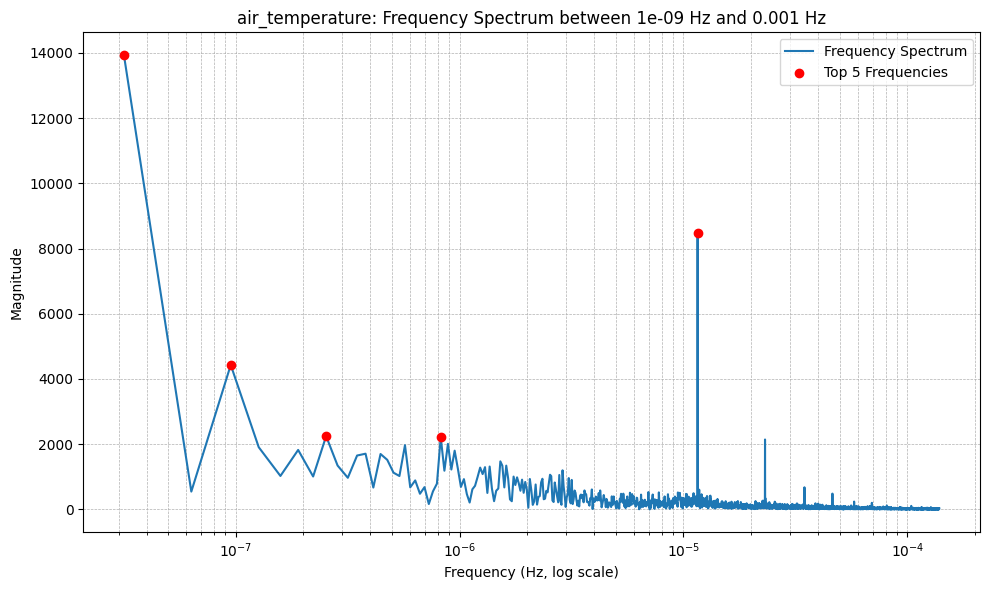

Top 5 frequencies with highest magnitude:
Frequency: 0.00000165 Hz, Period: 168.46 hours, Magnitude: 11431.0782
Frequency: 0.00000082 Hz, Period: 336.92 hours, Magnitude: 11977.4540
Frequency: 0.00000070 Hz, Period: 398.18 hours, Magnitude: 12196.4945
Frequency: 0.00001157 Hz, Period: 24.00 hours, Magnitude: 16031.6191
Frequency: 0.00000010 Hz, Period: 2920.00 hours, Magnitude: 21072.6988


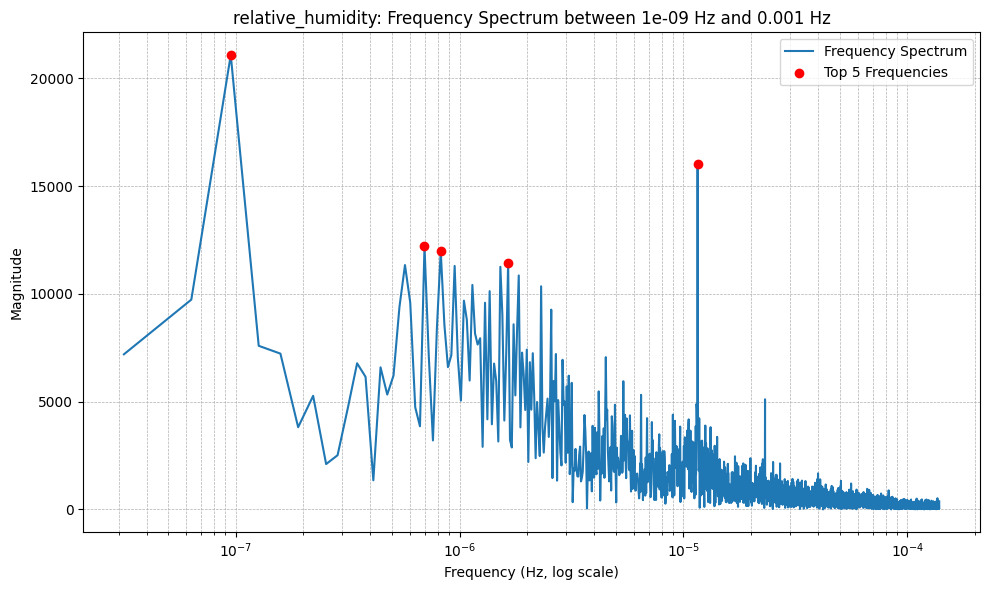

Top 5 frequencies with highest magnitude:
Frequency: 0.00002315 Hz, Period: 12.00 hours, Magnitude: 3694.6171
Frequency: 0.00000054 Hz, Period: 515.29 hours, Magnitude: 5177.6514
Frequency: 0.00000010 Hz, Period: 2920.00 hours, Magnitude: 5474.9733
Frequency: 0.00000006 Hz, Period: 4380.00 hours, Magnitude: 6374.4344
Frequency: 0.00000003 Hz, Period: 8760.00 hours, Magnitude: 11967.3121


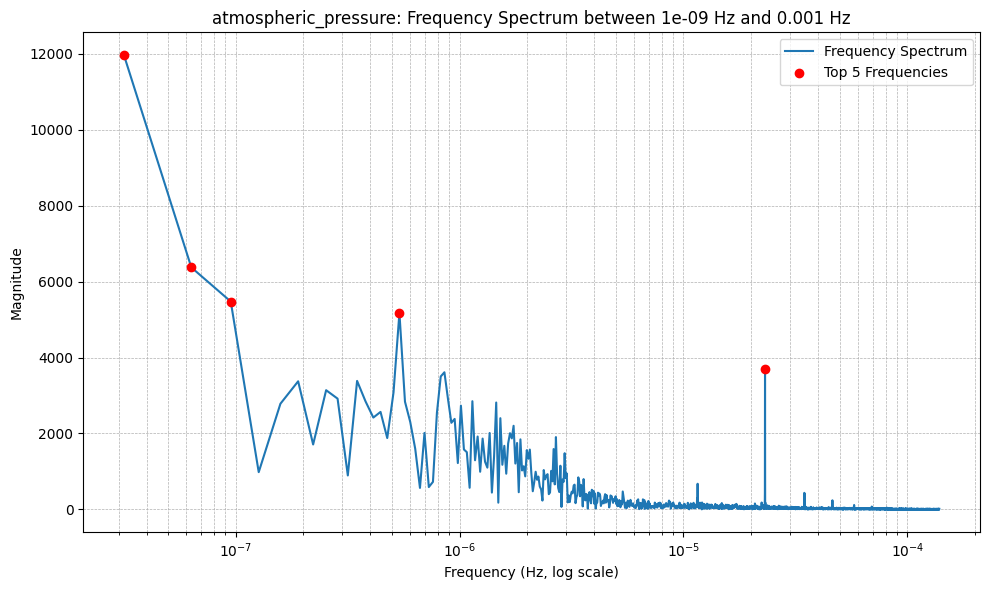

Plotting frequencies for openmeteo_buenavista_norte...
Top 5 frequencies with highest magnitude:
Frequency: 0.00000044 Hz, Period: 625.71 hours, Magnitude: 3200.0730
Frequency: 0.00000025 Hz, Period: 1095.00 hours, Magnitude: 3208.2092
Frequency: 0.00000010 Hz, Period: 2920.00 hours, Magnitude: 4933.6594
Frequency: 0.00001157 Hz, Period: 24.00 hours, Magnitude: 7021.1452
Frequency: 0.00000003 Hz, Period: 8760.00 hours, Magnitude: 12351.3705


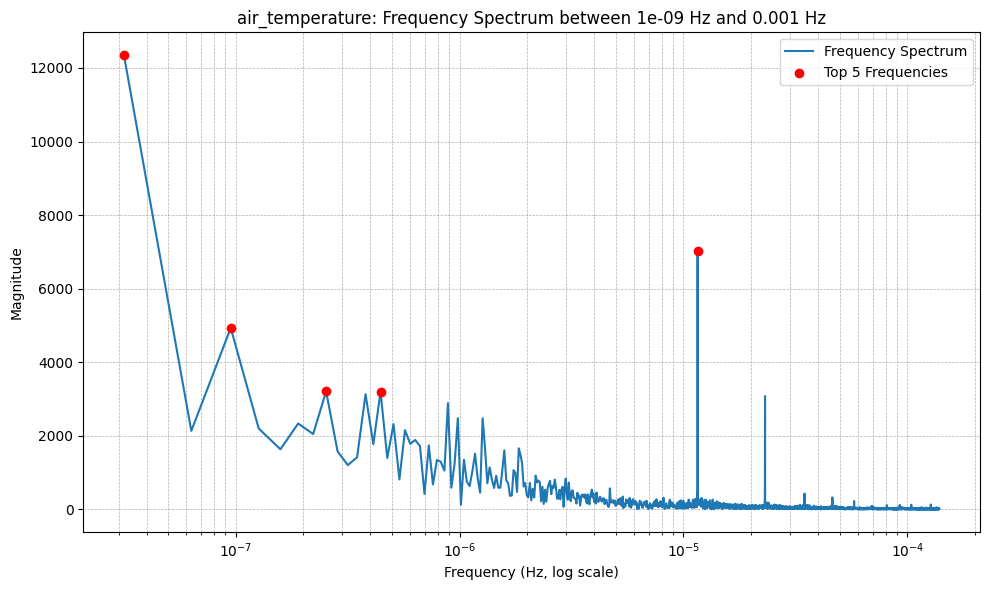

Top 5 frequencies with highest magnitude:
Frequency: 0.00000006 Hz, Period: 4380.00 hours, Magnitude: 13849.5203
Frequency: 0.00000025 Hz, Period: 1095.00 hours, Magnitude: 14946.7528
Frequency: 0.00000003 Hz, Period: 8760.00 hours, Magnitude: 16616.3567
Frequency: 0.00001157 Hz, Period: 24.00 hours, Magnitude: 23756.9706
Frequency: 0.00000010 Hz, Period: 2920.00 hours, Magnitude: 24290.9387


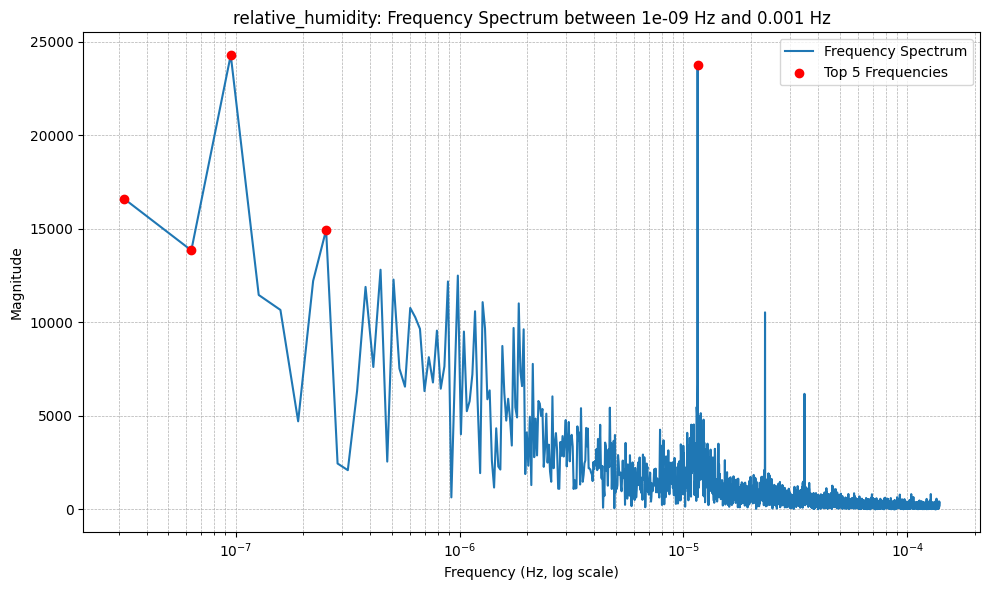

Top 5 frequencies with highest magnitude:
Frequency: 0.00002315 Hz, Period: 12.00 hours, Magnitude: 3482.5145
Frequency: 0.00000054 Hz, Period: 515.29 hours, Magnitude: 4517.3224
Frequency: 0.00000010 Hz, Period: 2920.00 hours, Magnitude: 5721.6143
Frequency: 0.00000006 Hz, Period: 4380.00 hours, Magnitude: 5940.1546
Frequency: 0.00000003 Hz, Period: 8760.00 hours, Magnitude: 11514.8874


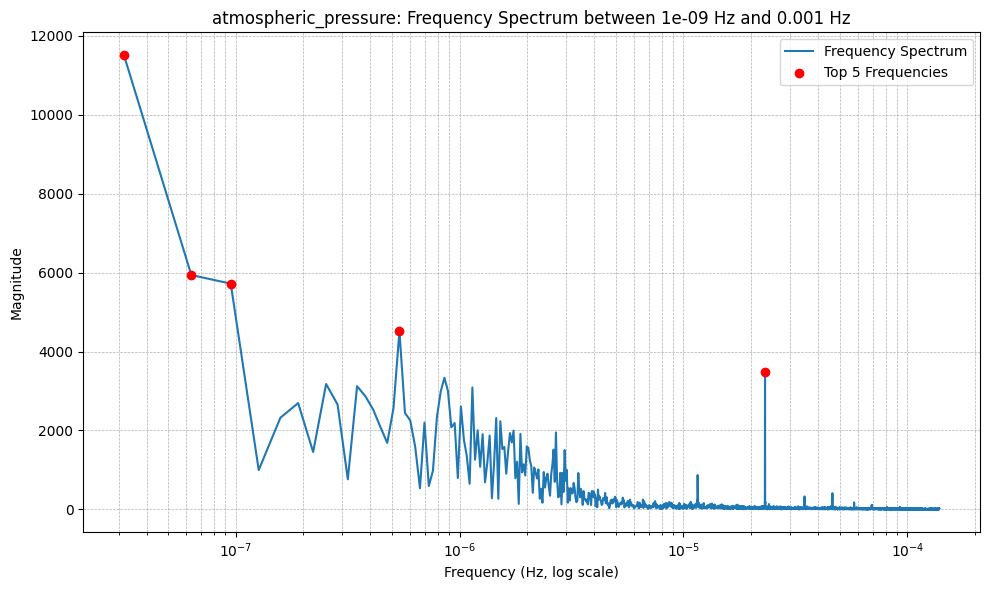

In [40]:
min_frequency = 10**-9
max_frequency = 10**-3
top_n = 5

for name, df in dataframes.items():
  print(f"Plotting frequencies for {name}...")
  plot_frequencies(df, "air_temperature", min_frequency, max_frequency, top_n)
  plot_frequencies(df, "relative_humidity", min_frequency, max_frequency, top_n)
  plot_frequencies(df, "atmospheric_pressure", min_frequency, max_frequency, top_n)

## Adición datos temporales

In [41]:
def add_time_features(df): 
    # Extract hour and minute to get a more continuous representation of time within a day
    df.index.name = "time"
    df.reset_index(inplace=True)

    df['time'] = pd.to_datetime(df['time'])
    hours = df['time'].dt.hour
    minutes  = df['time'].dt.minute
    hour_fraction = hours + minutes / 60.0

    # Convert the hour fraction into sine and cosine features to capture cyclical patterns (period = 24 hours)
    df['sin_day'] = np.sin(2 * np.pi * hour_fraction / 24)
    df['cos_day'] = np.cos(2 * np.pi * hour_fraction / 24)

    # Extract day of the week (0 = Monday, 6 = Sunday)
    day_of_week = df['time'].dt.weekday
    week_fraction = day_of_week + hour_fraction / 24.0  

    df['sin_week'] = np.sin(2 * np.pi * week_fraction / 7)
    df['cos_week'] = np.cos(2 * np.pi * week_fraction / 7)

    # For annual features: extract the day of the year (1-366)
    day_of_year = df['time'].dt.dayofyear

    # Subtracting 1 from day_of_year makes it start at 0, then add the fractional day.
    year_fraction = (day_of_year - 1) + hour_fraction / 24.0

    def is_leap_year(year):
        return (year % 4 == 0 and year % 100 != 0) or (year % 400 == 0)
    
    # Apply the leap year function and store the result
    df['leap_year'] = df['time'].dt.year.apply(is_leap_year)

    df['sin_year'] = np.sin(2 * np.pi * year_fraction / (365 + df['leap_year']))
    df['cos_year'] = np.cos(2 * np.pi * year_fraction / (365 + df['leap_year']))

    # Drop the aux leap year variable
    df.drop(columns="leap_year", inplace=True)
                            
    # Remove original time variable
    #df.drop(columns="time", inplace=True)
    
for df in dataframes.values():
    add_time_features(df)


Plotting correlations for grafcan_buenavista_norte...


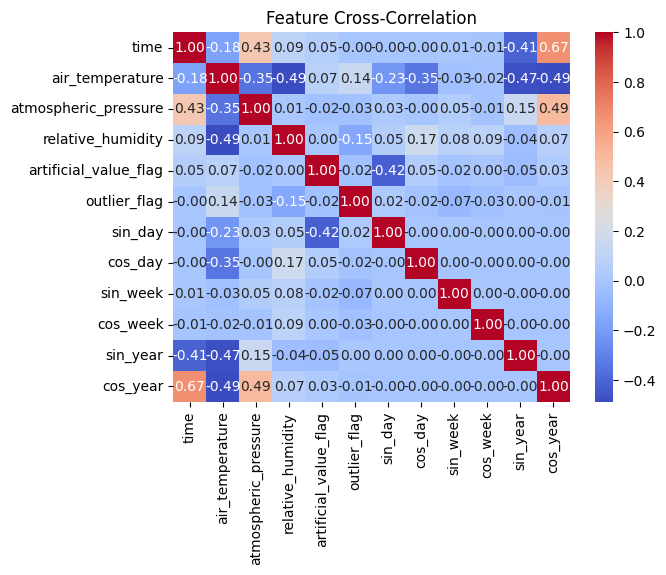

Plotting correlations for openmeteo_buenavista_norte...


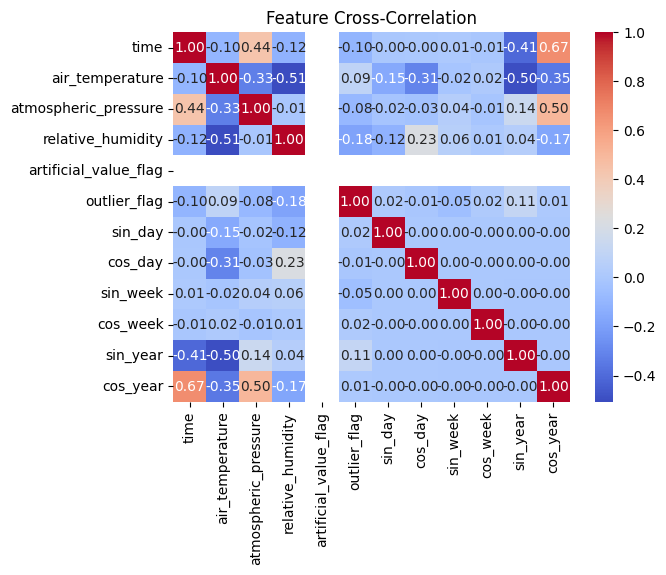

In [42]:
for name, df in dataframes.items():
  print (f"Plotting correlations for {name}...")
  
  correlation_matrix = df.corr()

  # Heatmap for visualization
  sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
  plt.title("Feature Cross-Correlation")
  plt.show()


In [43]:
for df in dataframes.values():
  df.drop(columns=["sin_week", "cos_week"], inplace=True)

## Escritura fichero 

In [44]:
for name, df in dataframes.items():
  df.to_csv("processed_data/" + name + "_features.csv", index=False)